In [1]:
import pandas as pd
import numpy as np

In [2]:
customer_data = pd.read_csv('Credit Card Customer Data.csv')
customer_data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
fraud_data = pd.read_csv('creditcard_for_fraud_detection.csv')
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
fraud_data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [46]:
## sepaprate the data one which contains anomlaies and other which do not contains anomalies
p = fraud_data['Class'] == 1
p2 = fraud_data['Class'] == 0
data_anomaly = fraud_data[:][p]
data_non_anomaly = fraud_data[:][p2]

In [53]:
print(f"Shape of data with anomaly : {data_anomaly.shape}")
print(f"Shape of data with non-anomaly : {data_non_anomaly.shape}")

Shape of data with anomaly : (492, 31)
Shape of data with non-anomaly : (284315, 31)


In [56]:
data_non_anomaly_train = data_non_anomaly[:280000]

data_anomaly_test = data_anomaly
data_non_anomaly_test = data_non_anomaly[280000:]

In [57]:
train_data = data_non_anomaly_train
test_data = pd.concat([data_anomaly_test, data_non_anomaly_test], axis=0)

print(f"Shape of training data : {train_data.shape}")
print(f"Shape of testing data : {test_data.shape}")

Shape of training data : (280000, 31)
Shape of testing data : (4807, 31)


In [58]:
## shuffling 
# Shuffle training data
train_data = train_data.sample(frac=1).reset_index(drop=True)

# Shuffle testing data
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [59]:
X_train = train_data.drop(columns=['Class'])
X_test = test_data.drop(columns=['Class'])
y_test = test_data['Class']

In [60]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [62]:
X_train[0].shape

(30,)

In [83]:
def find_mean_var(X):
    m, n = X.shape
    mu = np.zeros((1, n))
    var = np.zeros((1, n))

    for i in range(m):
        mu += X[i]
    mu /= m

    for i in range(m):
        var += (X[i] - mu)**2
    var /= m

    mu = mu.reshape(-1)
    var = var.reshape(-1)
    return mu, var

In [84]:
a1 = np.array([2, 4, 6])
v1 = np.array([2, 4, 6])

a1/v1

array([1., 1., 1.])

In [85]:
mean, variance = find_mean_var(X_train)

In [86]:
mean.shape

(30,)

In [87]:
def distribution(X, mu, var):
    return (np.exp(-1*((X-mu)**2/(2*var))))/(np.sqrt(2*3.14*np.sqrt(var)))

In [88]:
## making a function to find probabilities

def find_prob(mean, variance, X):
    m, n = X.shape
    probs = np.ones((m,))
    for i in range(m):
        for j in range(n):
            probs[i] *= distribution(X[i][j], mean[j], variance[j])
    
    probs = probs.reshape(-1)
    return probs

In [89]:
p_val = find_prob(mean, variance, X_test)

In [90]:
print(p_val.shape)

(4807,)


In [91]:
## Choosing a good value of epsilon
mini = min(p_val)
maxi = max(p_val)

In [97]:
def epsilon_value(y_val, p_val):


    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        ### START CODE HERE ### 
        m = len(y_val)
        tp = 0
        fp = 0
        fn = 0

       
        tp = np.sum((p_val < epsilon) & (y_val == 1))
        fp = np.sum((p_val < epsilon) & (y_val == 0))
        fn = np.sum((p_val >= epsilon) & (y_val == 1))
            
        if(tp == 0):
            continue
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        
        F1 = (2*prec*rec)/(prec + rec)
        print(f"Prec : {prec}, Recall : {rec}, F1 : {F1}")
        
        ### END CODE HERE ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [98]:
epsilon, score = epsilon_value(y_test, p_val)

Prec : 0.19576059850374064, Recall : 0.9573170731707317, F1 : 0.3250517598343685
Prec : 0.18206209275584515, Recall : 0.9654471544715447, F1 : 0.30635278942276684
Prec : 0.17472527472527472, Recall : 0.9695121951219512, F1 : 0.2960893854748603
Prec : 0.16914893617021276, Recall : 0.9695121951219512, F1 : 0.28804347826086957
Prec : 0.16551246537396122, Recall : 0.9715447154471545, F1 : 0.2828402366863905
Prec : 0.16197899017282277, Recall : 0.9715447154471545, F1 : 0.277664827185594
Prec : 0.15912117177097204, Recall : 0.9715447154471545, F1 : 0.2734553775743707
Prec : 0.1566383257030739, Recall : 0.9735772357723578, F1 : 0.26985915492957746
Prec : 0.15468901063486948, Recall : 0.975609756097561, F1 : 0.2670375521557719
Prec : 0.1526015228426396, Recall : 0.9776422764227642, F1 : 0.26399560922063664
Prec : 0.15078369905956113, Recall : 0.9776422764227642, F1 : 0.26127104834329173
Prec : 0.1497824735860783, Recall : 0.9796747967479674, F1 : 0.2598382749326145
Prec : 0.14785276073619633, 

In [101]:
epsilon

3.708607716728635e-20

In [102]:
X_test[234]

array([ 1.70556000e+05,  2.02236668e+00, -6.54733606e-01, -9.11969032e-01,
       -9.30467357e-01, -3.12132613e-01, -3.01213297e-01, -4.66449487e-01,
       -1.81204710e-01,  1.35969860e+00, -4.52583482e-01, -1.26152454e+00,
        1.03517247e+00,  2.13956540e+00, -4.66211273e-01,  1.10889904e+00,
        4.04026549e-01, -9.36132722e-01,  1.18635289e-01,  3.65433499e-01,
        7.38302931e-02,  1.64109350e-01,  6.48117118e-01, -5.62271513e-03,
       -9.39498966e-01, -1.71625700e-01,  7.62151808e-01, -3.32731437e-02,
       -5.09706016e-02,  5.50000000e+01])

In [103]:
y_test[234]

0

In [105]:
X_t = X_test[234].reshape(1, -1)

In [106]:
p_val = find_prob(mean, variance, X_t)

In [107]:
p_val

array([1.17877181e-20])

In [108]:
if p_val > epsilon:
    print(1)
else:
    print(0)

0


## Data Analysis using SVM

In [10]:
from sklearn.decomposition import PCA

In [11]:
X = fraud_data.drop(columns=['Time', 'Amount', 'Class'])
y = fraud_data['Class']
Time = fraud_data['Time']
Amount = fraud_data['Amount']

In [12]:
X = np.array(X)

In [14]:
X.shape

(284807, 28)

In [18]:
pca = PCA(n_components=1)
pca.fit(X)
pca.explained_variance_ratio_

array([0.12483757])

In [19]:
X_trans = pca.transform(X)

In [20]:
X_trans.shape

(284807, 1)

In [23]:
import matplotlib.pyplot as plt

X_trans = pd.DataFrame(X_trans, columns=['PCA'])

In [24]:
X_trans.head()

,PCA
0,1.359833
1,-1.191897
2,1.358316
3,0.966256
4,1.158204


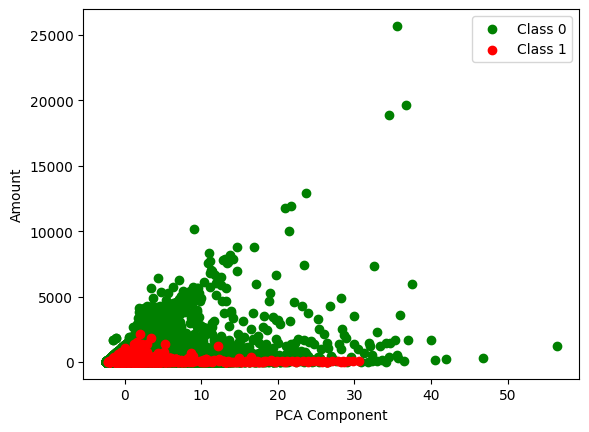

In [27]:
# Separate the data based on the class
class_0 = fraud_data['Class'] == 0
class_1 = fraud_data['Class'] == 1

plt.scatter(X_trans[class_0], Amount[class_0], color='green', label='Class 0')
plt.scatter(X_trans[class_1], Amount[class_1], color='red', label='Class 1')

plt.xlabel('PCA Component')
plt.ylabel('Amount')
plt.legend()
plt.show()


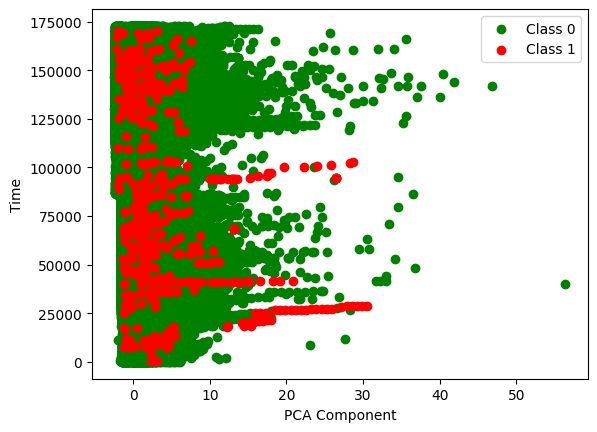

In [28]:
# Separate the data based on the class
class_0 = fraud_data['Class'] == 0
class_1 = fraud_data['Class'] == 1

plt.scatter(X_trans[class_0], Time[class_0], color='green', label='Class 0')
plt.scatter(X_trans[class_1], Time[class_1], color='red', label='Class 1')

plt.xlabel('PCA Component')
plt.ylabel('Time')
plt.legend()
plt.show()

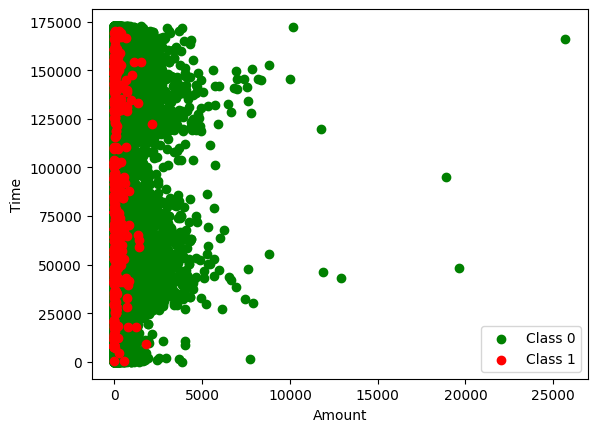

In [29]:
# Separate the data based on the class
class_0 = fraud_data['Class'] == 0
class_1 = fraud_data['Class'] == 1

plt.scatter(Amount[class_0], Time[class_0], color='green', label='Class 0')
plt.scatter(Amount[class_1], Time[class_1], color='red', label='Class 1')

plt.xlabel('Amount')
plt.ylabel('Time')
plt.legend()
plt.show()

In [31]:
def Normalize(mean, std, column):
    return (column - mean)/std

In [32]:
## Normalizing Amount and Time
mean_amt = np.mean(Amount)
std_amt = np.std(Amount)

mean_time = np.mean(Time)
std_time = np.std(Time)

Normalize_amount = Normalize(mean_amt, std_amt, Amount)
Normalize_time = Normalize(mean_time, std_time, Time)

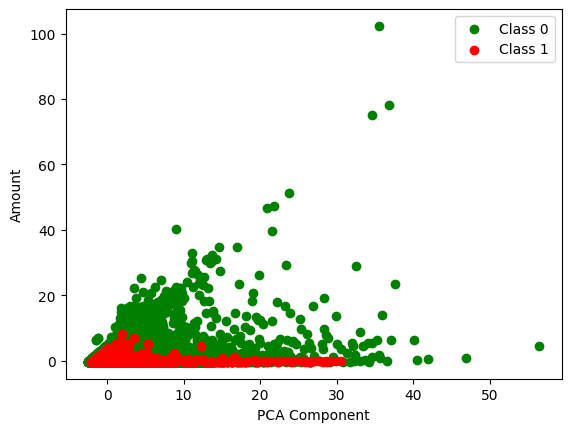

In [34]:
# Separate the data based on the class
class_0 = fraud_data['Class'] == 0
class_1 = fraud_data['Class'] == 1

plt.scatter(X_trans[class_0], Normalize_amount[class_0], color='green', label='Class 0')
plt.scatter(X_trans[class_1], Normalize_amount[class_1], color='red', label='Class 1')

plt.xlabel('PCA Component')
plt.ylabel('Amount')
plt.legend()
plt.show()

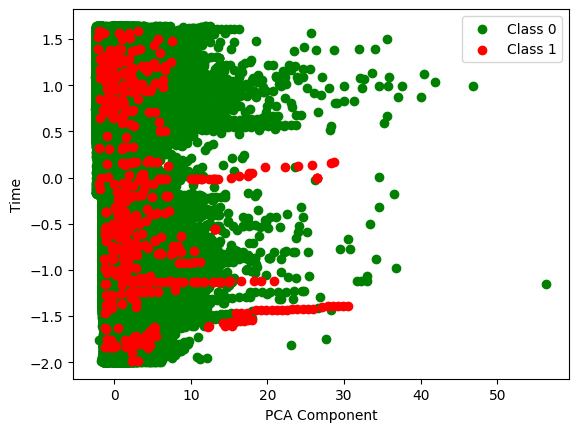

In [35]:
# Separate the data based on the class
class_0 = fraud_data['Class'] == 0
class_1 = fraud_data['Class'] == 1

plt.scatter(X_trans[class_0], Normalize_time[class_0], color='green', label='Class 0')
plt.scatter(X_trans[class_1], Normalize_time[class_1], color='red', label='Class 1')

plt.xlabel('PCA Component')
plt.ylabel('Time')
plt.legend()
plt.show()

## Using Isolation forest

In [2]:
data = pd.read_csv('creditcard_for_fraud_detection.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
## how many columns this data have : 
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
## unique values in time
data['Time'].value_counts()

Time
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
127750.0     1
62260.0      1
62259.0      1
127753.0     1
172792.0     1
Name: count, Length: 124592, dtype: int64

In [6]:
## checking for null
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
X = data.drop(columns=['Class'])
y = data['Class']

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
model = IsolationForest(contamination=0.00176, random_state=42)
model.fit(X)

IsolationForest(contamination=0.00176, random_state=42)

In [12]:
data['anomaly'] = model.predict(X)
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})

In [13]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,anomaly
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [14]:
# Evaluate the model
print(confusion_matrix(y, data['anomaly']))
print(classification_report(y, data['anomaly']))

[[283941    374]
 [   364    128]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.25      0.26      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807

